In [1]:
import pandas as pd
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rezar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rezar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rezar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Data

In [68]:
path = 'dataset/' #change to your data location
# load downloaded data
df_convos = pd.read_csv(path+'/conversations.csv')
df_speakers = pd.read_csv(path+'/speakers.csv')
df_utts = pd.read_csv(path+'/utterances.csv')
df_cases = pd.read_json(path_or_buf=path+'/cases.jsonl', lines=True)
df_cases = df_cases[(df_cases['year'] >= 2011) & (df_cases['year'] <= 2018) & (df_cases['win_side'].isin([0,1]))]

In [69]:
# count number win/lose cases
df_cases['win_side'].value_counts()

1.0    400
0.0    201
Name: win_side, dtype: int64

In [70]:
# combine text from all utterances in a conversation back into one string based on the conversation_id, coount how many utterances per conversation
utt_per_conv = df_utts.groupby('conversation_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
utt_per_conv['num_utterances'] = df_utts.groupby('conversation_id')['text'].count().reset_index()['text']

# add the combined text to the conversations dataframe, merge on conversation_id in utt_per_conv and id in df_convo
df_convos_utt = df_convos.merge(utt_per_conv, left_on='id', right_on='conversation_id', how='left')

In [71]:
# combine text from all conversation in a cases into one string based on the meta.case_id
conv_per_case = df_convos_utt.groupby('meta.case_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
conv_per_case['num_conversations'] = df_convos_utt.groupby('meta.case_id')['text'].count().reset_index()['text']
conv_per_case['num_utterances'] = df_convos_utt.groupby('meta.case_id')['num_utterances'].sum().reset_index()['num_utterances']

# add the combined text case dataframe, merge on meta.case_id and id
df_cases_convo = df_cases.merge(conv_per_case, left_on='id', right_on='meta.case_id', how='left')
df_cases_convo.head(1)

,id,year,citation,title,petitioner,respondent,docket_no,court,decided_date,url,...,win_side_detail,scdb_docket_id,votes,votes_detail,is_eq_divided,votes_side,meta.case_id,text,num_conversations,num_utterances
0,2011_11-1179,2011,567 US _,"American Tradition Partnership, Inc. v. Bullock","American Tradition Partnership, Inc.","Steve Bullock, Attorney General of Montana, et...",11-1179,Roberts Court,"Jun 25, 2012",https://www.oyez.org/cases/2011/11-1179,...,3.0,2011-073-01,"{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",NaN,NaN,NaN,NaN


In [72]:
df_cases_convo.dropna(subset=['text'], inplace=True)
df_cases_convo.shape[0]

521

In [73]:
# transform to pd.to_datetime
df_cases_convo.decided_date = pd.to_datetime(df_cases_convo.decided_date)

## Data Preprocessing

In [74]:
# Cleaning the text
def preprocess_text(text):
    text = text.lower() # Lowercase the text
    text = re.sub('[^a-z]+', ' ', text)  # Remove special characters and numbers
    text = re.sub(r'\b\w{1,3}\b', '', text) # Remove words with length less than 3
    words = nltk.word_tokenize(text) # Tokenize the text
    stop_words = set(stopwords.words('english')) # Remove stopwords
    words = [word for word in words if word not in stop_words]
    #lemmatizer = WordNetLemmatizer() # Lemmatize the words comment because slow
    #words = [lemmatizer.lemmatize(word) for word in words]
    stemmer = PorterStemmer() # Stem the words
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words) # Reconstruct the text

    return text

In [75]:
df_cases_convo.loc[:,'text'] = df_cases_convo.loc[:,'text'].apply(preprocess_text) #apply preprocess
df_cases_convo.to_csv('df_cases_clean.csv', index=False)

In [76]:
text = pd.read_csv('df_cases_clean.csv')
text.head(1)

,id,year,citation,title,petitioner,respondent,docket_no,court,decided_date,url,...,win_side_detail,scdb_docket_id,votes,votes_detail,is_eq_divided,votes_side,meta.case_id,text,num_conversations,num_utterances
0,2011_11-182,2011,567 US _,Arizona v. United States,Arizona et al.,United States,11-182,Roberts Court,2012-06-25,https://www.oyez.org/cases/2011/11-182,...,7.0,2011-075-01,"{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 0.0, 'j__antonin_scal...",2011_11-182,hear argument morn case arizona unit state cle...,1.0,295.0


In [105]:
df_cases_convo.columns

Index(['id', 'year', 'citation', 'title', 'petitioner', 'respondent',
       'docket_no', 'court', 'decided_date', 'url', 'transcripts',
       'adv_sides_inferred', 'known_respondent_adv', 'advocates', 'win_side',
       'win_side_detail', 'scdb_docket_id', 'votes', 'votes_detail',
       'is_eq_divided', 'votes_side', 'meta.case_id', 'text',
       'num_conversations', 'num_utterances', 'start_date', 'develop_time'],
      dtype='object')

In [77]:
# preprocess develop time
df_cases_convo.loc[:, 'start_date'] = df_cases_convo['transcripts'].apply(lambda x : re.findall(r'[A-Z][a-z]+ \d{2}, \d{4}', x[0]['name'])[0])
df_cases_convo.start_date = pd.to_datetime(df_cases_convo.start_date)
df_cases_convo.loc[:, 'develop_time'] = df_cases_convo.loc[:, 'decided_date'] - df_cases_convo.loc[:, 'start_date']

In [78]:
# get party of the judges
def check_party_pc(x):
    rep_judge = ['j__clarence_thomas', 'j__anthony_m_kennedy', 'j__antonin_scalia', 'j__john_g_roberts_jr', 'j__samuel_a_alito_jr',
             'j__john_paul_stevens', 'j__david_h_souter', 'j__william_h_rehnquist', 'j__neil_gorsuch', 'j__brett_m_kavanaugh']
    dem_judge = ['j__ruth_bader_ginsburg', 'j__stephen_g_breyer','j__sonia_sotomayor','j__elena_kagan']
    
    rep_ct = 0
    
    for judge in x:
        if judge in rep_judge:
            rep_ct += 1
    
    return rep_ct/len(x)

In [79]:
# get rep_judge yes
def check_rep_j_y_pc(x):
    rep_judge = ['j__clarence_thomas', 'j__anthony_m_kennedy', 'j__antonin_scalia', 'j__john_g_roberts_jr', 'j__samuel_a_alito_jr',
             'j__john_paul_stevens', 'j__david_h_souter', 'j__william_h_rehnquist', 'j__neil_gorsuch', 'j__brett_m_kavanaugh']
    dem_judge = ['j__ruth_bader_ginsburg', 'j__stephen_g_breyer','j__sonia_sotomayor','j__elena_kagan']
    
    rep_y_ct = 0
    
    for judge in x:
        if judge in rep_judge: 
            if x[judge] > 0:
                rep_y_ct += 1
    
    return rep_y_ct/len(x)

In [80]:
# get dem_judge yes
def check_dem_j_y_pc(x):
    rep_judge = ['j__clarence_thomas', 'j__anthony_m_kennedy', 'j__antonin_scalia', 'j__john_g_roberts_jr', 'j__samuel_a_alito_jr',
             'j__john_paul_stevens', 'j__david_h_souter', 'j__william_h_rehnquist', 'j__neil_gorsuch', 'j__brett_m_kavanaugh']
    dem_judge = ['j__ruth_bader_ginsburg', 'j__stephen_g_breyer','j__sonia_sotomayor','j__elena_kagan']
    
    dem_y_ct = 0
    
    for judge in x:
        if judge in dem_judge: 
            if x[judge] > 0:
                dem_y_ct += 1
    
    return dem_y_ct/len(x)

In [81]:
def check_party(x):
    if x > 2009:
        return 0
    else:
        return 1

In [82]:
# get M-F percentage in judges
def check_FM_jpc(x):
    male_judge = ['j__clarence_thomas', 
                  'j__anthony_m_kennedy', 
                  'j__antonin_scalia', 
                  'j__john_g_roberts_jr',
                  'j__samuel_a_alito_jr',
                  'j__john_paul_stevens', 
                  'j__david_h_souter', 
                  'j__william_h_rehnquist', 
                  'j__neil_gorsuch',
                  'j__brett_m_kavanaugh',
                  'j__stephen_g_breyer']
    female_judge = ['j__ruth_bader_ginsburg',
                    'j__sonia_sotomayor',
                    'j__elena_kagan']
    male_ct = 0
    for judge in x:
        if judge in male_judge:
            male_ct += 1
    
    return male_ct/len(x)

In [83]:
# get rep_judge yes
def check_M_j_y_pc(x):
    male_judge = ['j__clarence_thomas', 
                  'j__anthony_m_kennedy', 
                  'j__antonin_scalia', 
                  'j__john_g_roberts_jr',
                  'j__samuel_a_alito_jr',
                  'j__john_paul_stevens', 
                  'j__david_h_souter', 
                  'j__william_h_rehnquist', 
                  'j__neil_gorsuch',
                  'j__brett_m_kavanaugh',
                  'j__stephen_g_breyer']
    female_judge = ['j__ruth_bader_ginsburg',
                    'j__sonia_sotomayor',
                    'j__elena_kagan']
    male_y_ct = 0
    for judge in x:
        if judge in male_judge: 
            if x[judge] > 0:
                male_y_ct += 1
    return male_y_ct/len(x)

In [84]:
# get rep_judge yes
def check_F_j_y_pc(x):
    male_judge = ['j__clarence_thomas', 
                  'j__anthony_m_kennedy', 
                  'j__antonin_scalia', 
                  'j__john_g_roberts_jr',
                  'j__samuel_a_alito_jr',
                  'j__john_paul_stevens', 
                  'j__david_h_souter', 
                  'j__william_h_rehnquist', 
                  'j__neil_gorsuch',
                  'j__brett_m_kavanaugh',
                  'j__stephen_g_breyer']
    female_judge = ['j__ruth_bader_ginsburg',
                    'j__sonia_sotomayor',
                    'j__elena_kagan']
    female_y_ct = 0
    for judge in x:
        if judge in female_judge: 
            if x[judge] > 0:
                female_y_ct += 1
    return female_y_ct/len(x)

In [85]:
# get first name of speakers
df_test = df_cases_convo.loc[:, ['advocates']]

def get_side1_fstname(x):
    return list(x.keys())[0].split()[0]

def get_side0_fstname(x):
    try:
        return list(x.keys())[-1].split()[0]
    except:
        return list(x.keys())[-2].split()[0]
    
df_test.loc[:, 'side1_fstname'] = df_test['advocates'].apply(get_side1_fstname)
df_test.loc[:, 'side0_fstname'] = df_test['advocates'].apply(get_side0_fstname)

# read gender dataset
df_gender = pd.read_csv('dataset/name_gender_dataset.csv')
idx = df_gender.groupby(['Name'])['Probability'].idxmax()
df_gender = df_gender.loc[idx]

# join the gender dataset to predict gender of speakers
df_test = pd.merge(df_test, df_gender, how='left', left_on = 'side1_fstname', right_on = 'Name')
df_test = pd.merge(df_test, df_gender, how='left', left_on = 'side0_fstname', right_on = 'Name')

In [113]:
# only numbers can apply to Random Forest Model
df_rf = pd.DataFrame()
df_rf.loc[:, 'text_len'] = df_cases_convo['text'].apply(lambda x : len(x))
df_rf.loc[:, 'num_utterances'] = df_cases_convo['num_utterances']
df_rf.loc[:, 'win_side'] = df_cases_convo['win_side']
df_rf.loc[:, 'develop_time'] = df_cases_convo['develop_time'].apply(lambda x : x.days)
df_rf.loc[:, 'rep_jpc'] = df_cases_convo['votes_side'].apply(check_party_pc)
df_rf.loc[:, 'dem_jpc'] = 1 - df_rf.loc[:, 'rep_jpc']
df_rf.loc[:, 'rep_j_y_pc'] = df_cases_convo['votes_side'].apply(check_rep_j_y_pc)
df_rf.loc[:, 'dem_j_y_pc'] = df_cases_convo['votes_side'].apply(check_dem_j_y_pc)
df_rf.loc[:, 'party'] = df_cases_convo['year'].apply(check_party) # 1:  rep, 0: dem
df_rf.loc[:, 'male_jpc'] = df_cases_convo['votes_side'].apply(check_FM_jpc)
df_rf.loc[:, 'female_jpc'] = 1 - df_rf.loc[:, 'male_jpc']
df_rf.loc[:, 'male_y_jpc'] = df_cases_convo['votes_side'].apply(check_M_j_y_pc)
df_rf.loc[:, 'female_y_jpc'] = df_cases_convo['votes_side'].apply(check_F_j_y_pc)
df_rf.loc[:, 'text'] = df_cases_convo['text']
df_rf.loc[:, 'num_conversations'] = df_cases_convo['num_conversations']

# reset the index
df_rf = df_rf.reset_index(drop=True)
df_rf.loc[:, 'side1_gender'] = df_test['Gender_x'].apply(lambda x: 0 if(x == 'F') else 1)
df_rf.loc[:, 'side0_gender'] = df_test['Gender_y'].apply(lambda x: 0 if(x == 'F') else 1)

In [88]:
df_rf.to_csv('dataset/df_rf.csv', index=False)

In [3]:
df_rf = pd.read_csv('dataset/df_rf.csv')

### Additional Graphs for Checkpoint 1

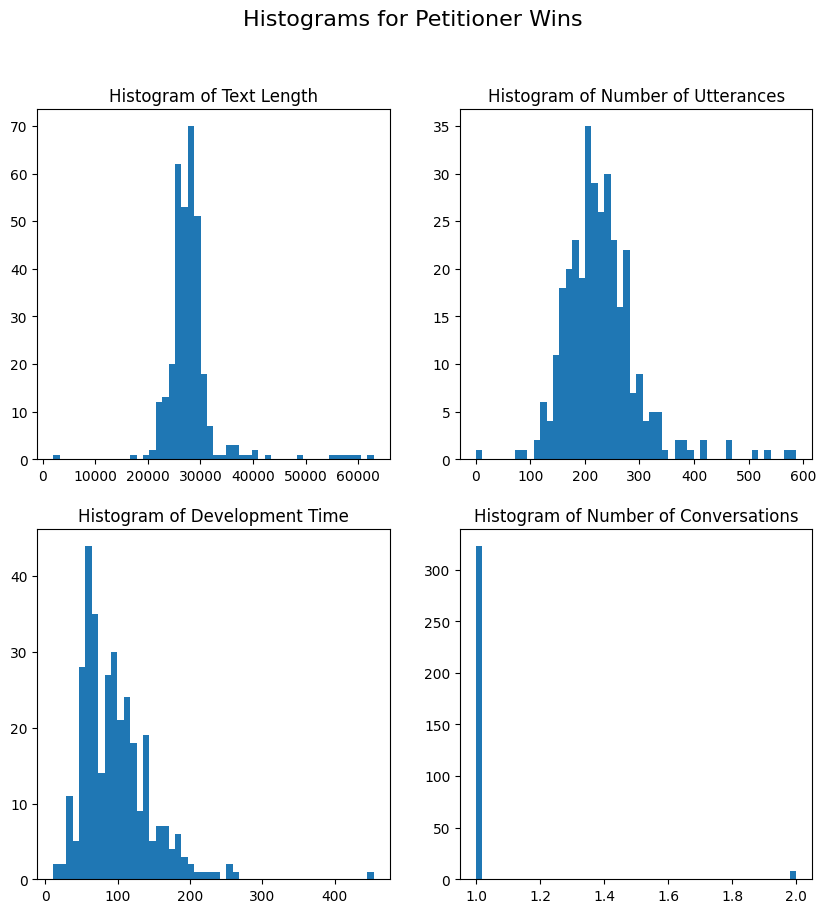

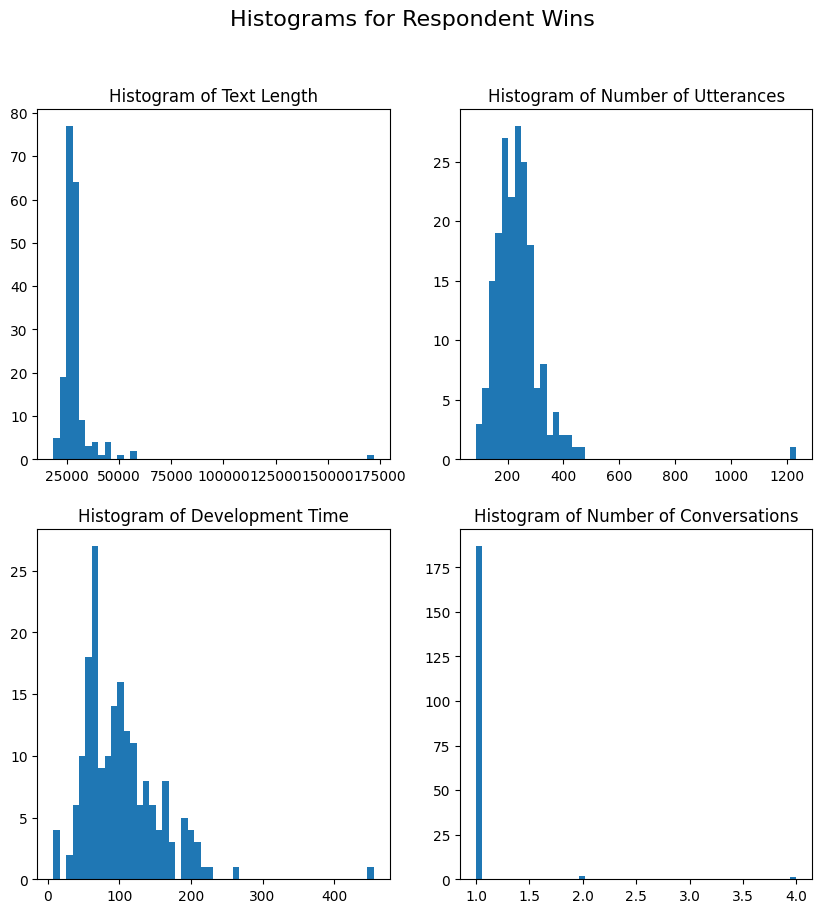

In [4]:
# Histogram of text length, number of utterances, and development time, and number of conversations for win_side = 1
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].hist(df_rf[df_rf['win_side'] == 1]['text_len'], bins=50)
ax[0, 0].set_title('Histogram of Text Length')
ax[0, 1].hist(df_rf[df_rf['win_side'] == 1]['num_utterances'], bins=50)
ax[0, 1].set_title('Histogram of Number of Utterances')
ax[1, 0].hist(df_rf[df_rf['win_side'] == 1]['develop_time'], bins=50)
ax[1, 0].set_title('Histogram of Development Time')
ax[1, 1].hist(df_rf[df_rf['win_side'] == 1]['num_conversations'], bins=50)
ax[1, 1].set_title('Histogram of Number of Conversations')
fig.suptitle('Histograms for Petitioner Wins', fontsize=16)
plt.savefig('histogram1.png')

# Histogram of text length, number of utterances, and development time, and number of conversations for win_side = 0
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].hist(df_rf[df_rf['win_side'] == 0]['text_len'], bins=50)
ax[0, 0].set_title('Histogram of Text Length')
ax[0, 1].hist(df_rf[df_rf['win_side'] == 0]['num_utterances'], bins=50)
ax[0, 1].set_title('Histogram of Number of Utterances')
ax[1, 0].hist(df_rf[df_rf['win_side'] == 0]['develop_time'], bins=50)
ax[1, 0].set_title('Histogram of Development Time')
ax[1, 1].hist(df_rf[df_rf['win_side'] == 0]['num_conversations'], bins=50)
ax[1, 1].set_title('Histogram of Number of Conversations')
fig.suptitle('Histograms for Respondent Wins', fontsize=16)
plt.savefig('histogram0.png')

## Baseline

In [5]:
# Calculate The Baseline for Accuracy, Precision, Recall, F1
accuracy = df_rf['win_side'].value_counts()[1]/df_rf['win_side'].shape[0]
print('Accuracy: ', accuracy)

Accuracy:  0.6353166986564299


## Model Selection and Vectorize

In [45]:
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
    f1_score, make_scorer, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc


def Classifier(X_train, X_test, y_train, y_test):

    # Train and evaluate the classifiers
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Naive Bayes": MultinomialNB(),
        "Linear SVC": LinearSVC(),
        "Random Forest": RandomForestClassifier(),
        "Perceptron": Perceptron(),
        "KNN": KNeighborsClassifier(n_neighbors=7)
        
    }

    results = []

    for classifier_name, classifier in classifiers.items():

        # Train the classifier
        classifier.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = classifier.predict(X_test)

        # Add the scores to the results dictionary
        results.append({
            'classifier': classifier_name,
            'accuracy': accuracy_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'True Negative Rate': confusion_matrix(y_test, y_pred)[0][0]/(confusion_matrix(y_test, y_pred)[0][0]+confusion_matrix(y_test, y_pred)[0][1]),
            'True Positive Rate': confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[1][1]+confusion_matrix(y_test, y_pred)[1][0]),
            'auc': roc_auc_score(y_test, y_pred)
        })
        
        # Make a confusion matrix
        print(f"Confusion Matrix for {classifier_name}:")
        
        if classifier_name == "Logistic Regression":
            print("Coefficients: \n", classifier.coef_)
        
        cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.set_title(f"CM {classifier_name}:")
        disp.plot(ax=ax)
        plt.show()
    return pd.DataFrame(results)

In [5]:
def Vectorize(vectorizer, X, y):
    X = vectorizer.fit_transform(X)
    y = y
    return X, y

### Using 'Text' as the feature

##### Text as Features and using TF-IDF Vectorizer

Confusion Matrix for Logistic Regression:
Coefficients: 
 [[ 0.11731986  0.04298986 -0.00358675 ... -0.0470672   0.00655914
   0.02283127]]


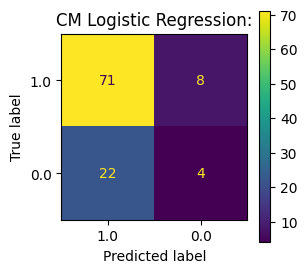

Confusion Matrix for Naive Bayes:


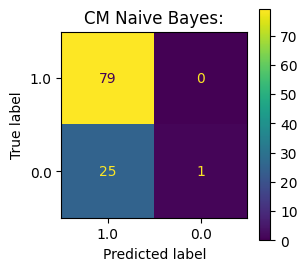

Confusion Matrix for Linear SVC:


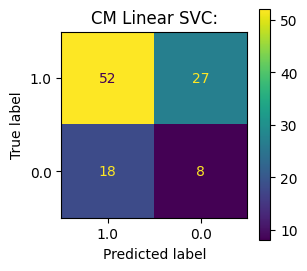

Confusion Matrix for Random Forest:


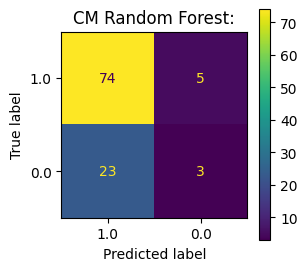

Confusion Matrix for Perceptron:


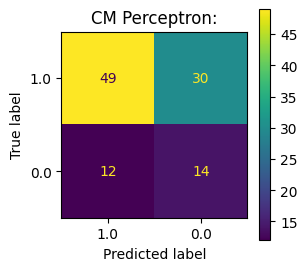

Confusion Matrix for KNN:


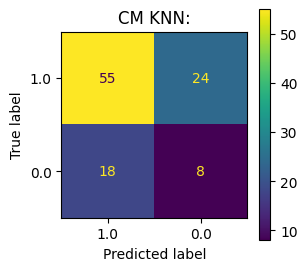

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.714286,0.825581,0.763441,0.898734,0.153846,0.898734,0.526290
1,Naive Bayes,0.761905,0.863388,0.759615,1.000000,0.038462,1.000000,0.519231
2,Linear SVC,0.571429,0.697987,0.742857,0.658228,0.307692,0.658228,0.482960
3,Random Forest,0.733333,0.840909,0.762887,0.936709,0.115385,0.936709,0.526047
4,Perceptron,0.600000,0.700000,0.803279,0.620253,0.538462,0.620253,0.579357
5,KNN,0.600000,0.723684,0.753425,0.696203,0.307692,0.696203,0.501947


In [10]:
# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(min_df=5, max_df=0.7)
X, y = Vectorize(vectorizer, df_rf['text'], df_rf['win_side'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier(X_train, X_test, y_train, y_test)

##### Text as Features and using Count Vectorizer

Confusion Matrix for Logistic Regression:


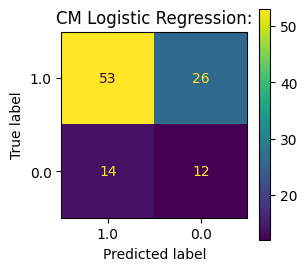

Confusion Matrix for Naive Bayes:


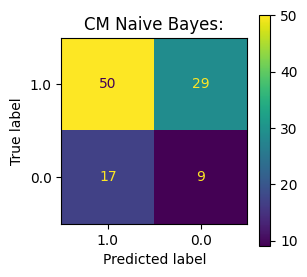

Confusion Matrix for Linear SVC:


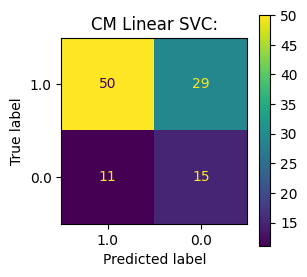

Confusion Matrix for Random Forest:


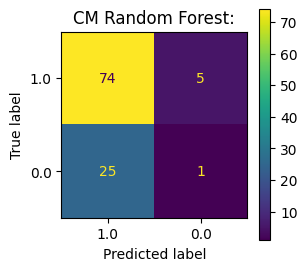

Confusion Matrix for Perceptron:


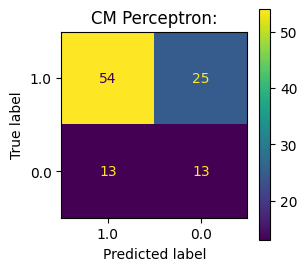

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.619048,0.726027,0.791045,0.670886,0.461538,0.670886,0.566212
1,Naive Bayes,0.561905,0.684932,0.746269,0.632911,0.346154,0.632911,0.489533
2,Linear SVC,0.619048,0.714286,0.819672,0.632911,0.576923,0.632911,0.604917
3,Random Forest,0.714286,0.831461,0.747475,0.936709,0.038462,0.936709,0.487585
4,Perceptron,0.638095,0.739726,0.805970,0.683544,0.500000,0.683544,0.591772


In [9]:
# Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.8)
X, y = Vectorize(vectorizer, df_rf['text'], df_rf['win_side'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier(X_train, X_test, y_train, y_test)

##### Text as Features and using TF-IDF Vectorizer and using Over and Under Sampling

--OVERSAMPLING--
Confusion Matrix for Logistic Regression:


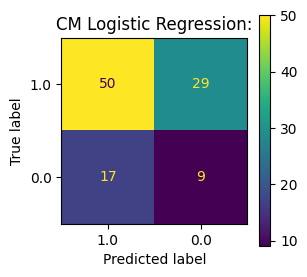

Confusion Matrix for Naive Bayes:


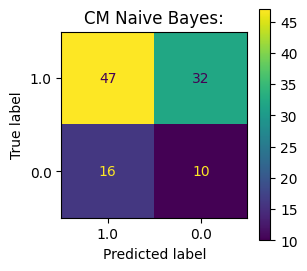

Confusion Matrix for Linear SVC:


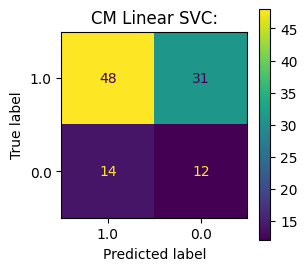

Confusion Matrix for Random Forest:


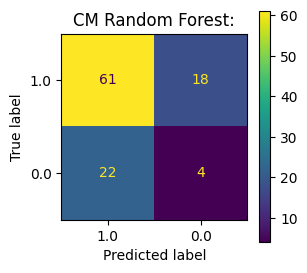

Confusion Matrix for Perceptron:


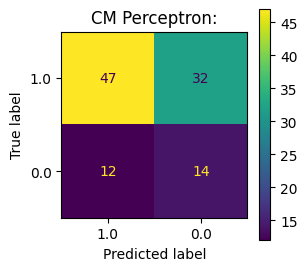

            classifier  accuracy        f1  precision    recall  \
0  Logistic Regression  0.561905  0.684932   0.746269  0.632911   
1          Naive Bayes  0.542857  0.661972   0.746032  0.594937   
2           Linear SVC  0.571429  0.680851   0.774194  0.607595   
3        Random Forest  0.619048  0.753086   0.734940  0.772152   
4           Perceptron  0.580952  0.681159   0.796610  0.594937   

   True Negative Rate  True Positive Rate       auc  
0            0.346154            0.632911  0.489533  
1            0.384615            0.594937  0.489776  
2            0.461538            0.607595  0.534567  
3            0.153846            0.772152  0.462999  
4            0.538462            0.594937  0.566699  
--UNDERSAMPLING--
Confusion Matrix for Logistic Regression:


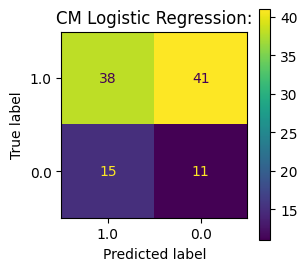

Confusion Matrix for Naive Bayes:


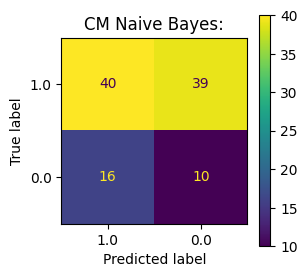

Confusion Matrix for Linear SVC:


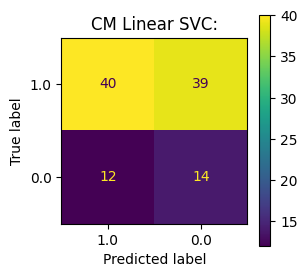

Confusion Matrix for Random Forest:


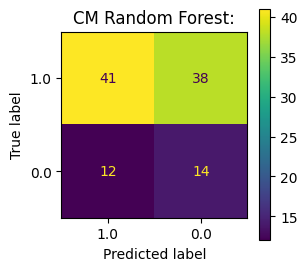

Confusion Matrix for Perceptron:


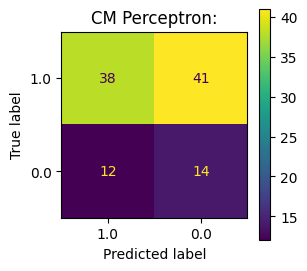

            classifier  accuracy        f1  precision    recall  \
0  Logistic Regression  0.466667  0.575758   0.716981  0.481013   
1          Naive Bayes  0.476190  0.592593   0.714286  0.506329   
2           Linear SVC  0.514286  0.610687   0.769231  0.506329   
3        Random Forest  0.523810  0.621212   0.773585  0.518987   
4           Perceptron  0.495238  0.589147   0.760000  0.481013   

   True Negative Rate  True Positive Rate       auc  
0            0.423077            0.481013  0.452045  
1            0.384615            0.506329  0.445472  
2            0.538462            0.506329  0.522395  
3            0.538462            0.518987  0.528724  
4            0.538462            0.481013  0.509737  


In [11]:
# USING IMBLEARN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

vectorizer = TfidfVectorizer(min_df=5, max_df=0.8)
X, y = Vectorize(vectorizer, df_rf['text'], df_rf['win_side'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)


# Resample the training data
print('--OVERSAMPLING--')
ros = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
classifier = Classifier(X_train_resampled, X_test, y_train_resampled, y_test)
print(classifier)

print('--UNDERSAMPLING--')
ros = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
classifier = Classifier(X_train_resampled, X_test, y_train_resampled, y_test)
print(classifier)

#### Try using k-fold cross validation

In [33]:
from sklearn.model_selection import cross_val_score

def Classifier_kfold(X, y):

    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Naive Bayes": MultinomialNB(),
        "Linear SVC": LinearSVC(),
        "Random Forest": RandomForestClassifier(),
        "Perceptron": Perceptron(),
    }

    results = []

    for classifier_name, classifier in classifiers.items():

        # Perform k-fold cross-validation
        scores = cross_val_score(classifier, X, y, cv=5, scoring='accuracy')  # 5-fold cross-validation
        # Add the scores to the results list
        results.append({
            'classifier': classifier_name,
            'mean_f1': scores.mean(),
            'std_f1': scores.std(),
        })

        print(f"f1 for {classifier_name}: {scores.mean()} (+/- {scores.std() * 2})")

    return pd.DataFrame(results)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(min_df=5, max_df=0.7)
X, y = Vectorize(vectorizer, df_rf['text'], df_rf['win_side'])
Classifier_kfold(X, y)

f1 for Logistic Regression: 0.6237912087912088 (+/- 0.008850077622725633)
f1 for Naive Bayes: 0.6353113553113553 (+/- 0.002783882783882774)
f1 for Linear SVC: 0.6083333333333334 (+/- 0.06005147912118134)
f1 for Random Forest: 0.6276373626373626 (+/- 0.03304313560378509)
f1 for Perceptron: 0.5853663003663004 (+/- 0.054826294118804415)


,classifier,mean_f1,std_f1
0,Logistic Regression,0.623791,0.004425
1,Naive Bayes,0.635311,0.001392
2,Linear SVC,0.608333,0.030026
3,Random Forest,0.627637,0.016522
4,Perceptron,0.585366,0.027413


#### Using ngrams

Confusion Matrix for Logistic Regression:
Coefficients: 
 [[ 0.01914151  0.05325384 -0.01408864 ... -0.01701203 -0.00579603
  -0.16882371]]


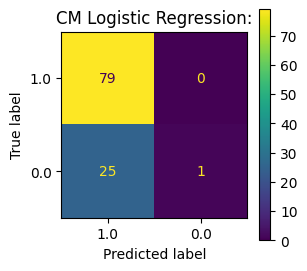

Confusion Matrix for Naive Bayes:


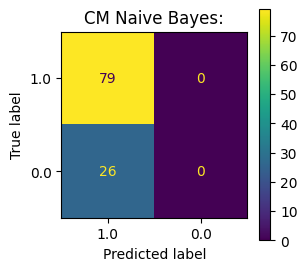

Confusion Matrix for Linear SVC:


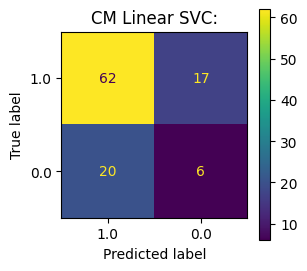

Confusion Matrix for Random Forest:


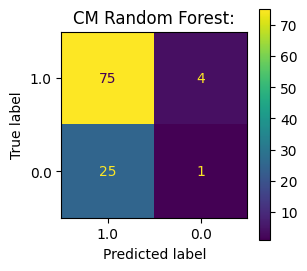

Confusion Matrix for Perceptron:


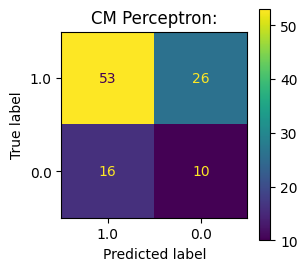

Confusion Matrix for KNN:


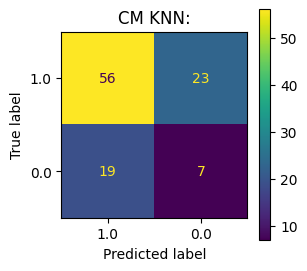

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.761905,0.863388,0.759615,1.000000,0.038462,1.000000,0.519231
1,Naive Bayes,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
2,Linear SVC,0.647619,0.770186,0.756098,0.784810,0.230769,0.784810,0.507790
3,Random Forest,0.723810,0.837989,0.750000,0.949367,0.038462,0.949367,0.493914
4,Perceptron,0.600000,0.716216,0.768116,0.670886,0.384615,0.670886,0.527751
5,KNN,0.600000,0.727273,0.746667,0.708861,0.269231,0.708861,0.489046


In [11]:
# Vectorize the text using TF-IDF and bigrams
vectorizer = TfidfVectorizer(min_df=5, max_df=0.7, ngram_range =(2, 2))
X, y = Vectorize(vectorizer, df_rf['text'], df_rf['win_side'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier(X_train, X_test, y_train, y_test)

Confusion Matrix for Logistic Regression:
Coefficients: 
 [[-0.09237814  0.07358038  0.09318226 ...  0.07050802  0.00746334
  -0.24805484]]


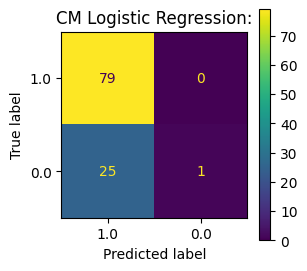

Confusion Matrix for Naive Bayes:


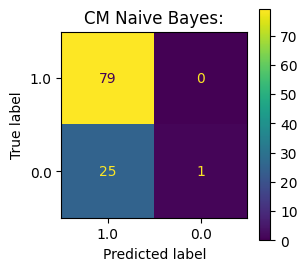

Confusion Matrix for Linear SVC:


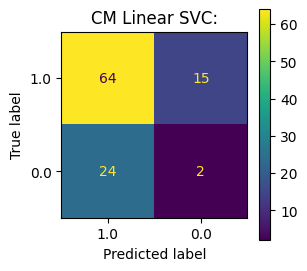

Confusion Matrix for Random Forest:


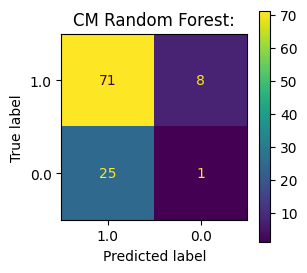

Confusion Matrix for Perceptron:


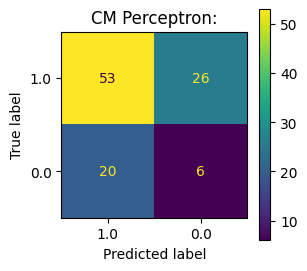

Confusion Matrix for KNN:


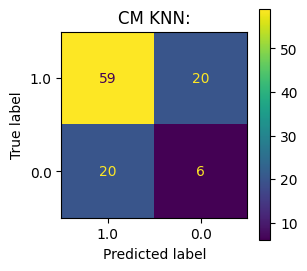

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.761905,0.863388,0.759615,1.000000,0.038462,1.000000,0.519231
1,Naive Bayes,0.761905,0.863388,0.759615,1.000000,0.038462,1.000000,0.519231
2,Linear SVC,0.628571,0.766467,0.727273,0.810127,0.076923,0.810127,0.443525
3,Random Forest,0.685714,0.811429,0.739583,0.898734,0.038462,0.898734,0.468598
4,Perceptron,0.561905,0.697368,0.726027,0.670886,0.230769,0.670886,0.450828
5,KNN,0.619048,0.746835,0.746835,0.746835,0.230769,0.746835,0.488802


In [12]:
# Vectorize the text using TF-IDF: Trigrams
vectorizer = TfidfVectorizer(min_df=5, max_df=0.7, ngram_range =(3, 3))
X, y = Vectorize(vectorizer, df_rf['text'], df_rf['win_side'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier(X_train, X_test, y_train, y_test)

Confusion Matrix for Logistic Regression:
Coefficients: 
 [[ 0.09887798  0.01125257  0.02364326 ...  0.02447635 -0.08093888
  -0.04026498]]


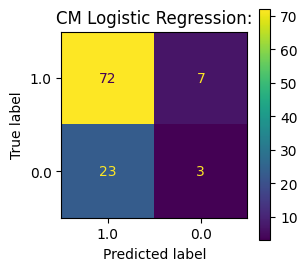

Confusion Matrix for Naive Bayes:


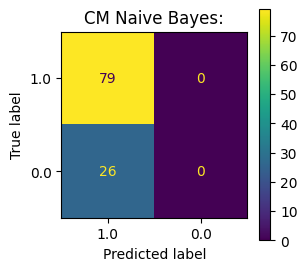

Confusion Matrix for Linear SVC:


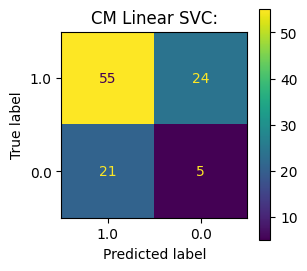

Confusion Matrix for Random Forest:


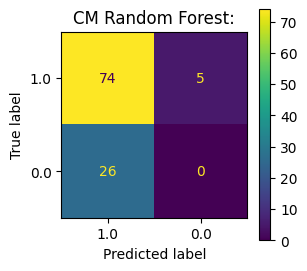

Confusion Matrix for Perceptron:


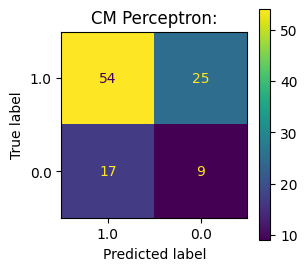

Confusion Matrix for KNN:


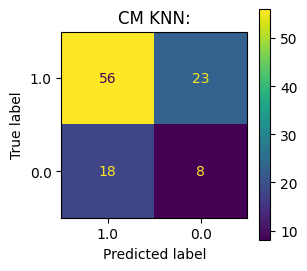

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.714286,0.827586,0.757895,0.911392,0.115385,0.911392,0.513389
1,Naive Bayes,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
2,Linear SVC,0.571429,0.709677,0.723684,0.696203,0.192308,0.696203,0.444255
3,Random Forest,0.704762,0.826816,0.740000,0.936709,0.000000,0.936709,0.468354
4,Perceptron,0.600000,0.720000,0.760563,0.683544,0.346154,0.683544,0.514849
5,KNN,0.609524,0.732026,0.756757,0.708861,0.307692,0.708861,0.508277


In [13]:
# Vectorize the text using TF-IDF: range 1 to 3 grams
vectorizer = TfidfVectorizer(min_df=5, max_df=0.7, ngram_range =(1, 3))
X, y = Vectorize(vectorizer, df_rf['text'], df_rf['win_side'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier(X_train, X_test, y_train, y_test)

In [70]:
# Calculate The Baseline based on y_test
accuracy = y_test.value_counts()[1]/y_test.shape[0]
print('Accuracy: ', accuracy)

Accuracy:  0.7523809523809524


### Using 'Text' + rep_pct + male_jpc + develop_time as the feature

Confusion Matrix for Logistic Regression:
Coefficients: 
 [[ 0.01900358  0.05249416 -0.01398821 ...  0.01246409 -0.08228093
  -0.00045653]]


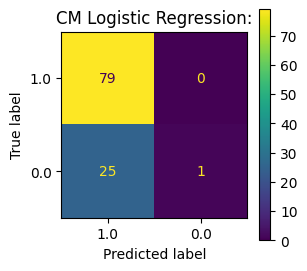

Confusion Matrix for Naive Bayes:


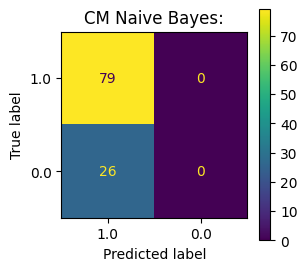

Confusion Matrix for Linear SVC:


C:\Users\rezar\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


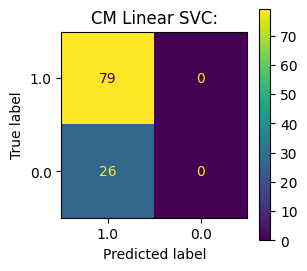

Confusion Matrix for Random Forest:


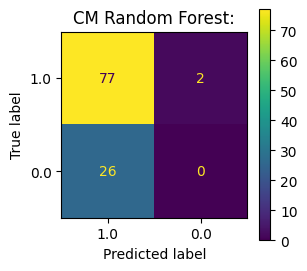

Confusion Matrix for Perceptron:


C:\Users\rezar\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


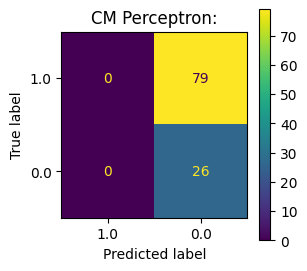

Confusion Matrix for KNN:


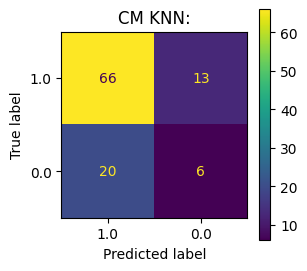

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.761905,0.863388,0.759615,1.000000,0.038462,1.000000,0.519231
1,Naive Bayes,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
2,Linear SVC,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
3,Random Forest,0.733333,0.846154,0.747573,0.974684,0.000000,0.974684,0.487342
4,Perceptron,0.247619,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000
5,KNN,0.685714,0.800000,0.767442,0.835443,0.230769,0.835443,0.533106


In [14]:
tfidf = TfidfVectorizer(min_df=5, max_df=0.8,ngram_range =(2, 2))
X_text = tfidf.fit_transform(df_rf['text'])
X_rep_pct = np.array(df_rf['rep_jpc']).reshape(-1, 1)
X_male_jpc = np.array(df_rf['male_jpc']).reshape(-1, 1)
X_dev_time = np.array(df_rf['develop_time']).reshape(-1, 1)
X_party = np.array(df_rf['party']).reshape(-1, 1)
y = df_rf['win_side']
# Horizontally stack the TF-IDF other features
X = np.hstack((X_text.toarray(), X_rep_pct, X_male_jpc, X_dev_time))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier(X_train, X_test, y_train, y_test)

### Using 'Text' + rep_pct + male_jpc as the feature

Confusion Matrix for Logistic Regression:
Coefficients: 
 [[ 0.01901738  0.05252966 -0.01400972 ... -0.16520139  0.01492379
  -0.00045276]]


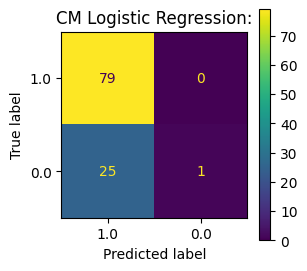

Confusion Matrix for Naive Bayes:


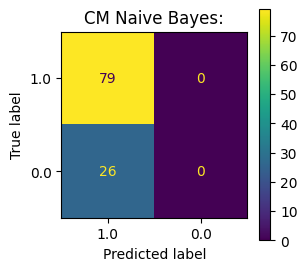

Confusion Matrix for Linear SVC:


C:\Users\rezar\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


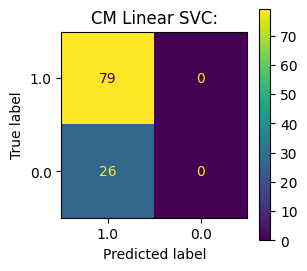

Confusion Matrix for Random Forest:


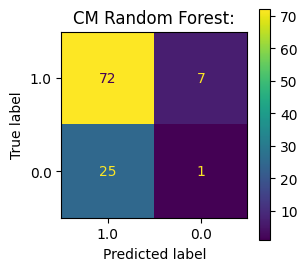

Confusion Matrix for Perceptron:


C:\Users\rezar\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


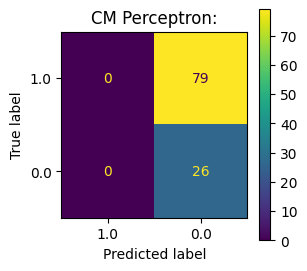

Confusion Matrix for KNN:


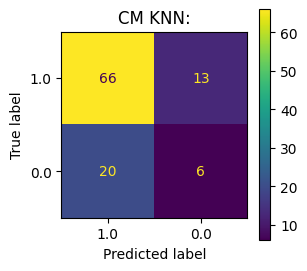

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.761905,0.863388,0.759615,1.000000,0.038462,1.000000,0.519231
1,Naive Bayes,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
2,Linear SVC,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
3,Random Forest,0.695238,0.818182,0.742268,0.911392,0.038462,0.911392,0.474927
4,Perceptron,0.247619,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000
5,KNN,0.685714,0.800000,0.767442,0.835443,0.230769,0.835443,0.533106


In [15]:
tfidf = TfidfVectorizer(min_df=5, max_df=0.8,ngram_range =(2, 2))
X_text = tfidf.fit_transform(df_rf['text'])
X_rep_pct = np.array(df_rf['rep_jpc']).reshape(-1, 1)
X_male_jpc = np.array(df_rf['male_jpc']).reshape(-1, 1)
X_dev_time = np.array(df_rf['develop_time']).reshape(-1, 1)
X_party = np.array(df_rf['party']).reshape(-1, 1)
y = df_rf['win_side']
# Horizontally stack the TF-IDF other features
X = np.hstack((X_text.toarray(), X_rep_pct, X_dev_time))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier(X_train, X_test, y_train, y_test)

### Using 'Text' + male_jpc + develop_time as the feature

Confusion Matrix for Logistic Regression:
Coefficients: 
 [[ 0.01866398  0.05256018 -0.01407685 ... -0.16448145 -0.03192788
  -0.00044994]]


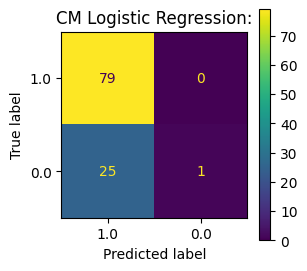

Confusion Matrix for Naive Bayes:


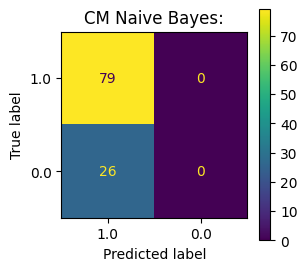

Confusion Matrix for Linear SVC:


C:\Users\rezar\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\rezar\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


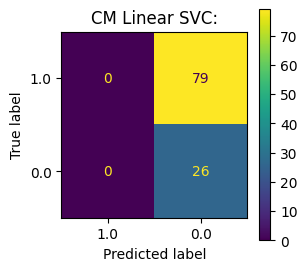

Confusion Matrix for Random Forest:


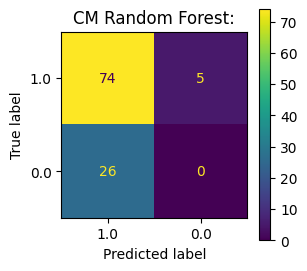

Confusion Matrix for Perceptron:


C:\Users\rezar\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


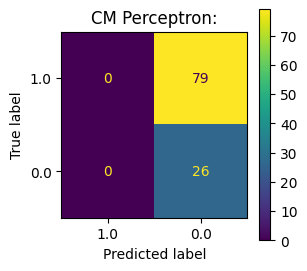

Confusion Matrix for KNN:


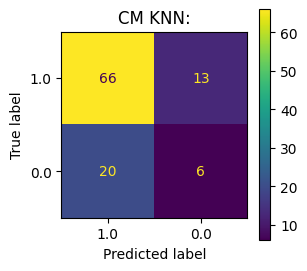

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.761905,0.863388,0.759615,1.000000,0.038462,1.000000,0.519231
1,Naive Bayes,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
2,Linear SVC,0.247619,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000
3,Random Forest,0.704762,0.826816,0.740000,0.936709,0.000000,0.936709,0.468354
4,Perceptron,0.247619,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000
5,KNN,0.685714,0.800000,0.767442,0.835443,0.230769,0.835443,0.533106


In [16]:
tfidf = TfidfVectorizer(min_df=5, max_df=0.8,ngram_range =(2, 2))
X_text = tfidf.fit_transform(df_rf['text'])
X_rep_pct = np.array(df_rf['rep_jpc']).reshape(-1, 1)
X_male_jpc = np.array(df_rf['male_jpc']).reshape(-1, 1)
X_dev_time = np.array(df_rf['develop_time']).reshape(-1, 1)
X_party = np.array(df_rf['party']).reshape(-1, 1)
y = df_rf['win_side']
# Horizontally stack the TF-IDF other features
X = np.hstack((X_text.toarray(), X_male_jpc, X_dev_time))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier(X_train, X_test, y_train, y_test)

### Using 'Text' + rep_jpc as the feature


Confusion Matrix for Logistic Regression:
Coefficients: 
 [[ 1.91723738e-02  5.28830096e-02 -1.40558302e-02 ... -5.77817776e-03
  -1.68158369e-01 -1.17107435e-04]]


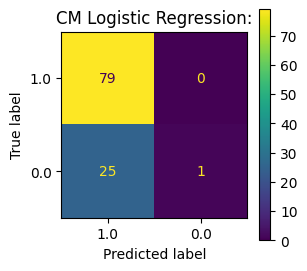

Confusion Matrix for Naive Bayes:


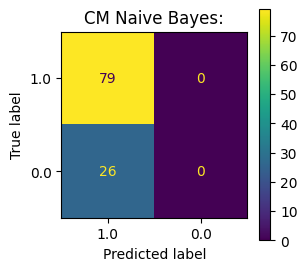

Confusion Matrix for Linear SVC:


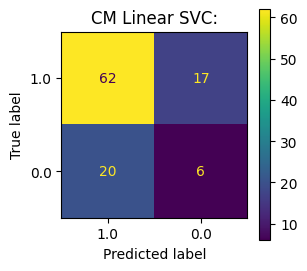

Confusion Matrix for Random Forest:


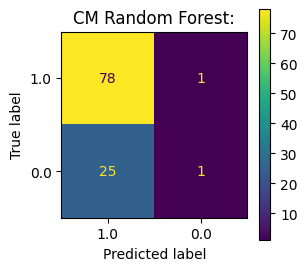

Confusion Matrix for Perceptron:


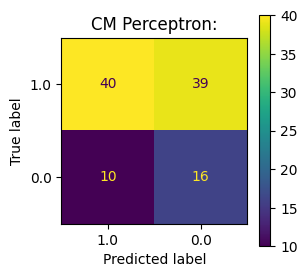

Confusion Matrix for KNN:


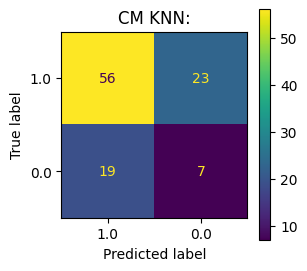

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.761905,0.863388,0.759615,1.000000,0.038462,1.000000,0.519231
1,Naive Bayes,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
2,Linear SVC,0.647619,0.770186,0.756098,0.784810,0.230769,0.784810,0.507790
3,Random Forest,0.752381,0.857143,0.757282,0.987342,0.038462,0.987342,0.512902
4,Perceptron,0.533333,0.620155,0.800000,0.506329,0.615385,0.506329,0.560857
5,KNN,0.600000,0.727273,0.746667,0.708861,0.269231,0.708861,0.489046


In [17]:
tfidf = TfidfVectorizer(min_df=5, max_df=0.8, ngram_range =(2, 2))
X_text = tfidf.fit_transform(df_rf['text'])
X_rep_pct = np.array(df_rf['rep_jpc']).reshape(-1, 1)
X_male_jpc = np.array(df_rf['male_jpc']).reshape(-1, 1)
X_dev_time = np.array(df_rf['develop_time']).reshape(-1, 1)
X_party = np.array(df_rf['party']).reshape(-1, 1)
y = df_rf['win_side']
# Horizontally stack the TF-IDF other features
X = np.hstack((X_text.toarray(), X_rep_pct))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier(X_train, X_test, y_train, y_test)

### Using 'Text' + male_jpc as the feature


Confusion Matrix for Logistic Regression:
Coefficients: 
 [[ 0.01916319  0.05289112 -0.01406044 ... -0.00579865 -0.16836936
  -0.0928783 ]]


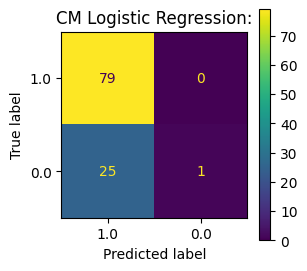

Confusion Matrix for Naive Bayes:


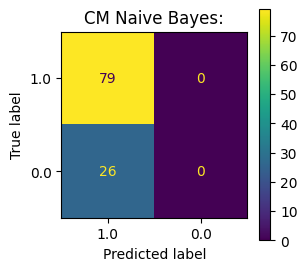

Confusion Matrix for Linear SVC:


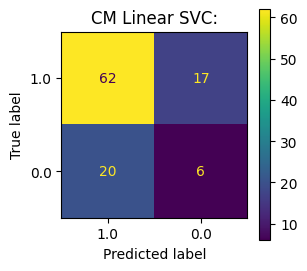

Confusion Matrix for Random Forest:


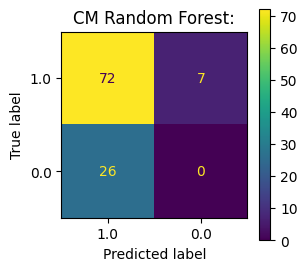

Confusion Matrix for Perceptron:


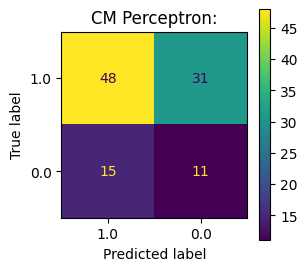

Confusion Matrix for KNN:


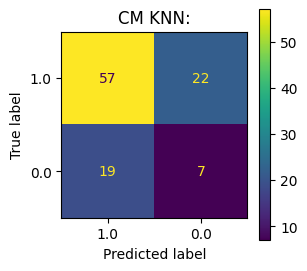

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.761905,0.863388,0.759615,1.000000,0.038462,1.000000,0.519231
1,Naive Bayes,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
2,Linear SVC,0.647619,0.770186,0.756098,0.784810,0.230769,0.784810,0.507790
3,Random Forest,0.685714,0.813559,0.734694,0.911392,0.000000,0.911392,0.455696
4,Perceptron,0.561905,0.676056,0.761905,0.607595,0.423077,0.607595,0.515336
5,KNN,0.609524,0.735484,0.750000,0.721519,0.269231,0.721519,0.495375


In [18]:
tfidf = TfidfVectorizer(min_df=5, max_df=0.8,ngram_range =(2, 2))
X_text = tfidf.fit_transform(df_rf['text'])
X_rep_pct = np.array(df_rf['rep_jpc']).reshape(-1, 1)
X_male_jpc = np.array(df_rf['male_jpc']).reshape(-1, 1)
X_dev_time = np.array(df_rf['develop_time']).reshape(-1, 1)
X_party = np.array(df_rf['party']).reshape(-1, 1)
y = df_rf['win_side']
# Horizontally stack the TF-IDF other features
X = np.hstack((X_text.toarray(), X_male_jpc))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier(X_train, X_test, y_train, y_test)

### Using 'Text' + dev_time as the feature


Confusion Matrix for Logistic Regression:
Coefficients: 
 [[ 0.01901232  0.05250654 -0.01401245 ... -0.00578631 -0.16533421
  -0.00045581]]


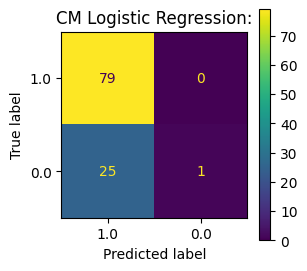

Confusion Matrix for Naive Bayes:


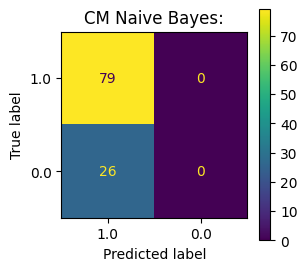

C:\Users\rezar\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Confusion Matrix for Linear SVC:


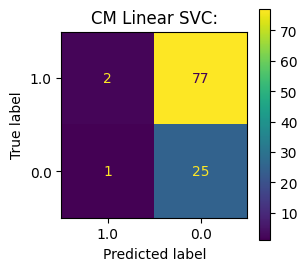

Confusion Matrix for Random Forest:


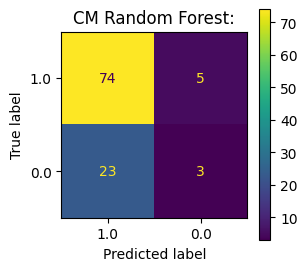

Confusion Matrix for Perceptron:


C:\Users\rezar\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


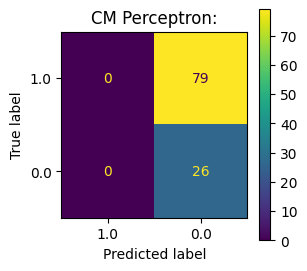

Confusion Matrix for KNN:


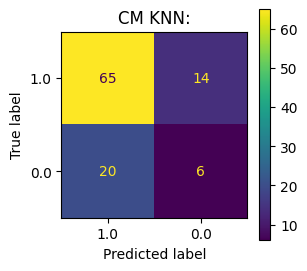

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.761905,0.863388,0.759615,1.000000,0.038462,1.000000,0.519231
1,Naive Bayes,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
2,Linear SVC,0.257143,0.048780,0.666667,0.025316,0.961538,0.025316,0.493427
3,Random Forest,0.733333,0.840909,0.762887,0.936709,0.115385,0.936709,0.526047
4,Perceptron,0.247619,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000
5,KNN,0.676190,0.792683,0.764706,0.822785,0.230769,0.822785,0.526777


In [29]:
tfidf = TfidfVectorizer(min_df=5, max_df=0.8,ngram_range =(2, 2))
X_text = tfidf.fit_transform(df_rf['text'])
X_rep_pct = np.array(df_rf['rep_jpc']).reshape(-1, 1)
X_male_jpc = np.array(df_rf['male_jpc']).reshape(-1, 1)
X_dev_time = np.array(df_rf['develop_time']).reshape(-1, 1)
X_party = np.array(df_rf['party']).reshape(-1, 1)
y = df_rf['win_side']
# Horizontally stack the TF-IDF other features
X = np.hstack((X_text.toarray(), X_dev_time))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier(X_train, X_test, y_train, y_test)

Confusion Matrix for Logistic Regression:
Coefficients: 
 [[ 0.01901232  0.05250654 -0.01401245 ... -0.00578631 -0.16533421
  -0.00045581]]


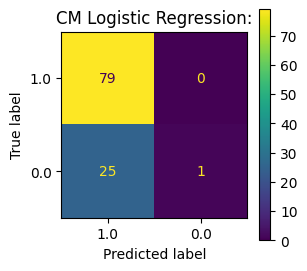

Confusion Matrix for Naive Bayes:


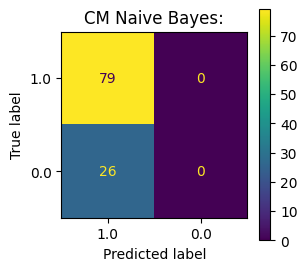

Confusion Matrix for Linear SVC:


C:\Users\rezar\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


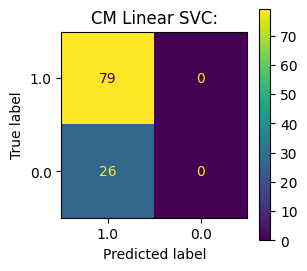

Confusion Matrix for Random Forest:


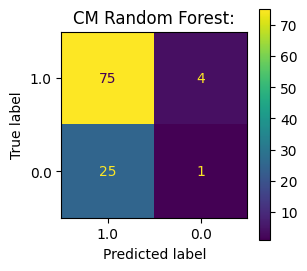

Confusion Matrix for Perceptron:


C:\Users\rezar\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


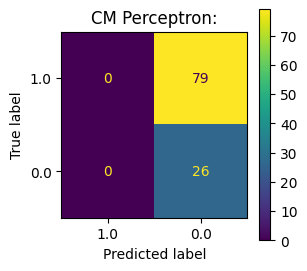

Confusion Matrix for KNN:


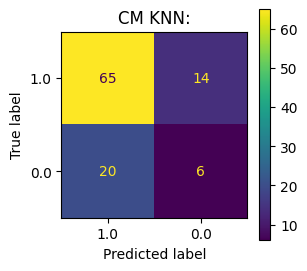

Confusion Matrix for Logistic Regression:
Coefficients: 
 [[ 0.01863534  0.06180091 -0.01704493 ... -0.00818723 -0.12273915
  -0.00084728]]


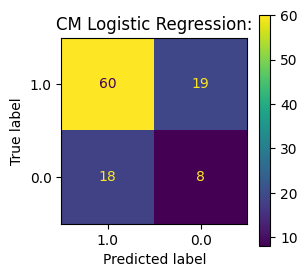

Confusion Matrix for Naive Bayes:


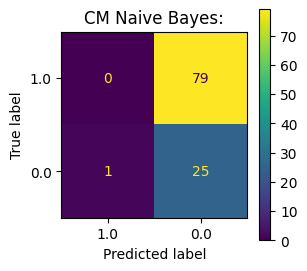

Confusion Matrix for Linear SVC:


C:\Users\rezar\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


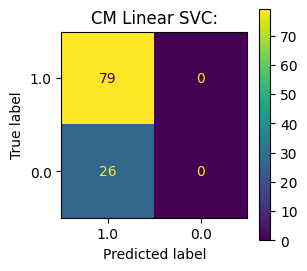

Confusion Matrix for Random Forest:


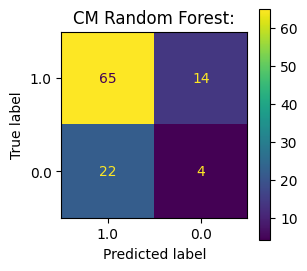

Confusion Matrix for Perceptron:


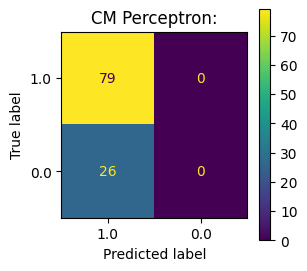

Confusion Matrix for KNN:


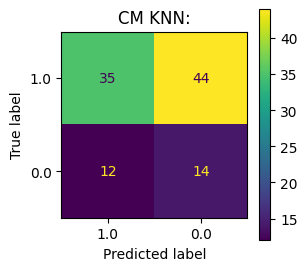

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.647619,0.764331,0.769231,0.759494,0.307692,0.759494,0.533593
1,Naive Bayes,0.238095,0.000000,0.000000,0.000000,0.961538,0.000000,0.480769
2,Linear SVC,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
3,Random Forest,0.657143,0.783133,0.747126,0.822785,0.153846,0.822785,0.488315
4,Perceptron,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
5,KNN,0.466667,0.555556,0.744681,0.443038,0.538462,0.443038,0.490750


In [20]:
# USING IMBLEARN
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier(X_train, X_test, y_train, y_test)
ros = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
Classifier(X_train_resampled, X_test, y_train_resampled, y_test)

#### Check using different hyperparameter

C:\Users\rezar\AppData\Local\Temp\ipykernel_10152\1042704739.py:19: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  scores_matrix = results.pivot(index='param_penalty', columns='param_C', values='mean_test_score')


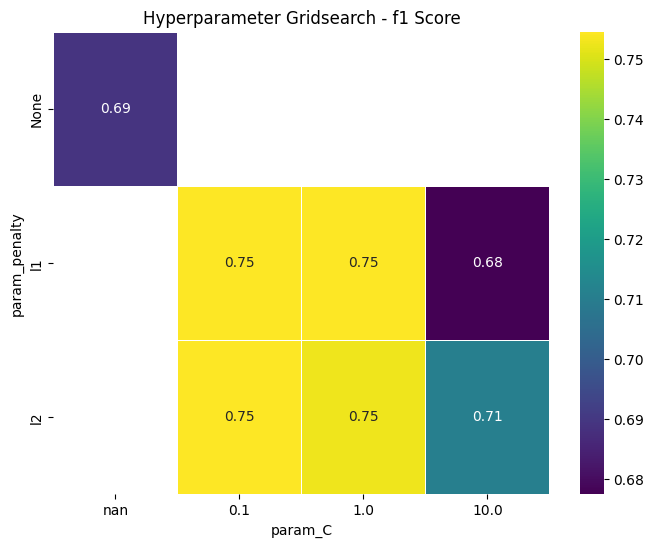

In [57]:
from sklearn.model_selection import GridSearchCV
vectorizer = TfidfVectorizer(min_df=5, max_df=0.7, ngram_range =(2, 2))
X, y = Vectorize(vectorizer, df_rf['text'], df_rf['win_side'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

#load hyperparam
param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear'], 'C': [0.1, 1, 10]},
    {'penalty': ['l2'], 'solver': ['lbfgs'], 'C': [0.1, 1, 10]},
    {'penalty': [None], 'solver': ['lbfgs']},
]

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=10, scoring='f1', 
                    return_train_score=True, error_score=np.nan)
grid.fit(X_train, y_train)

results = pd.DataFrame(grid.cv_results_)
results['param_penalty'] = results['param_penalty'].astype('str')
scores_matrix = results.pivot(index='param_penalty', columns='param_C', values='mean_test_score')

plt.figure(figsize=(8, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".2f", linewidths=.5, cmap='viridis')
plt.title('Hyperparameter Gridsearch - f1 Score')
plt.show()

#### Trying using pretrained model
Try using pretrained model from transformers.

https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads

In [38]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments


# Load your data
data = pd.read_csv('text_clean.csv')

# Swapped 0 and 1 in win_side
# data['win_side'] = data['win_side'].apply(lambda x: 0 if x == 1 else 1)

# Split your data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(data['text'], data['win_side'], test_size=0.2, stratify=data['win_side'], random_state=55)

# Initialize the BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


# Tokenize the text data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

# Create PyTorch Class from dataset
class SCOTUSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).long()
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SCOTUSDataset(train_encodings, train_labels.tolist())
test_dataset = SCOTUSDataset(test_encodings, test_labels.tolist())

# Initialize the BERT model for sequence classification
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=2, #changed to 2 because the GPU
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=1000,
    load_best_model_at_end=True,
)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

# Evaluate the model
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.label_ids
y_pred = (predictions.predictions.argmax(-1)).tolist()

# Calculate performance metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

Step,Training Loss,Validation Loss
100,0.694300,0.668718
200,0.664300,0.656595
300,0.687600,0.654255
400,0.679200,0.660695
500,0.673700,0.654594
600,0.694700,0.651798
700,0.651100,0.674763
800,0.680400,0.689492
900,0.686100,0.665781
1000,0.670000,0.656918


Accuracy: 0.6381
Precision: 0.6381
Recall: 1.0000
F1-Score: 0.7791


In [59]:
def Classifier2(X_train, X_test, y_train, y_test):

    # Train and evaluate the classifiers
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000, penalty='l2', C=1, solver='lbfgs'),
        "Naive Bayes": MultinomialNB(),
        "Linear SVC": LinearSVC(),
        "Random Forest": RandomForestClassifier(),
        "Perceptron": Perceptron(),
        "KNN": KNeighborsClassifier(n_neighbors=11)
        
    }
    results = []

    for classifier_name, classifier in classifiers.items():

        # Train the classifier
        classifier.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = classifier.predict(X_test)

        # Add the scores to the results dictionary
        results.append({
            'classifier': classifier_name,
            'accuracy': accuracy_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'True Negative Rate': confusion_matrix(y_test, y_pred)[0][0]/(confusion_matrix(y_test, y_pred)[0][0]+confusion_matrix(y_test, y_pred)[0][1]),
            'True Positive Rate': confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[1][1]+confusion_matrix(y_test, y_pred)[1][0]),
            'auc': roc_auc_score(y_test, y_pred)
        })
        
        # Make a confusion matrix
        print(f"Confusion Matrix for {classifier_name}:")
        
        if classifier_name == "Logistic Regression":
            print("Coefficients: \n", classifier.coef_)
        
        cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.set_title(f"CM {classifier_name}:")
        disp.plot(ax=ax)
        plt.show()
    return pd.DataFrame(results)

Confusion Matrix for Logistic Regression:
Coefficients: 
 [[ 0.01914151  0.05325384 -0.01408864 ... -0.01701203 -0.00579603
  -0.16882371]]


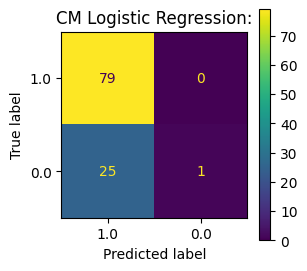

Confusion Matrix for Naive Bayes:


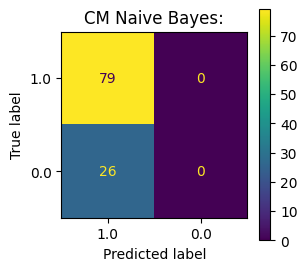

Confusion Matrix for Linear SVC:


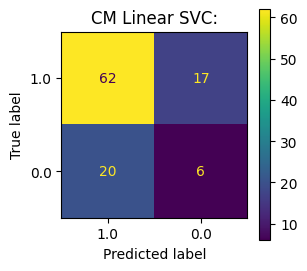

Confusion Matrix for Random Forest:


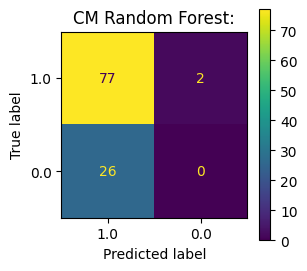

Confusion Matrix for Perceptron:


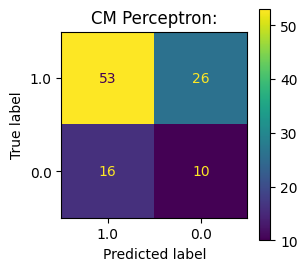

Confusion Matrix for KNN:


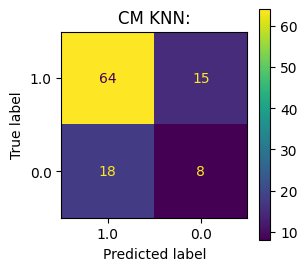

,classifier,accuracy,f1,precision,recall,True Negative Rate,True Positive Rate,auc
0,Logistic Regression,0.761905,0.863388,0.759615,1.000000,0.038462,1.000000,0.519231
1,Naive Bayes,0.752381,0.858696,0.752381,1.000000,0.000000,1.000000,0.500000
2,Linear SVC,0.647619,0.770186,0.756098,0.784810,0.230769,0.784810,0.507790
3,Random Forest,0.733333,0.846154,0.747573,0.974684,0.000000,0.974684,0.487342
4,Perceptron,0.600000,0.716216,0.768116,0.670886,0.384615,0.670886,0.527751
5,KNN,0.685714,0.795031,0.780488,0.810127,0.307692,0.810127,0.558909


In [60]:
X, y = Vectorize(vectorizer, df_rf['text'], df_rf['win_side'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
Classifier2(X_train, X_test, y_train, y_test)